In [0]:
##### import tensorflow as tf
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop,Adam

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
"""
Loading MNIST Dataset
"""

def load_mnist():
    (x_train,y_train), (x_test,y_test) = mnist.load_data()
    
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.

    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))

    return (x_train, y_train), (x_test, y_test)

In [0]:
"""
Initial CNN Model
"""
def build_simple_model():
    inputs = layers.Input(shape=(28,28,1))
    x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', name="Conv1")(inputs)
    x = layers.Conv2D(64, kernel_size=(3,3), activation='relu', name="Conv2")(x)
    
    x = layers.MaxPooling2D(pool_size=(2,2), name='MaxPool')(x)
    x = layers.Dropout(rate=0.25, name='Dropout1')(x)
    
    x = layers.Flatten(name='Flat')(x)
    x = layers.Dense(128, activation='relu', name='FC1')(x)
    x = layers.Dropout(rate=0.5, name='Dropout2')(x)

    
    x = layers.Dense(10, name='logits')(x)
    preds = layers.Activation('softmax', name='Softmax')(x)

    model = Model(inputs=inputs, outputs=preds)
    model.summary()
    return model

In [0]:
model = build_simple_model()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
Conv2 (Conv2D)               (None, 24, 24, 64)        18496     
_________________________________________________________________
MaxPool (MaxPooling2D)       (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 12, 12, 64)        0         
_________________________________________________________________
Flat (Flatten)               (None, 9216)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               1179

In [0]:
(x_train, y_train), (x_test, y_test) = load_mnist()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=64)  

Epoch 1/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.2041 - acc: 0.9380
Epoch 2/10
60000/60000 [==============================] - 5s 85us/sample - loss: 0.0802 - acc: 0.9763
Epoch 3/10
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0608 - acc: 0.9809
Epoch 4/10
60000/60000 [==============================] - 5s 84us/sample - loss: 0.0492 - acc: 0.9851
Epoch 5/10
60000/60000 [==============================] - 5s 84us/sample - loss: 0.0415 - acc: 0.9869
Epoch 6/10
60000/60000 [==============================] - 5s 84us/sample - loss: 0.0376 - acc: 0.9880
Epoch 7/10
60000/60000 [==============================] - 5s 84us/sample - loss: 0.0348 - acc: 0.9889
Epoch 8/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.0272 - acc: 0.9913
Epoch 9/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.0259 - acc: 0.9915
Epoch 10/10
60000/60000 [==============================] - 5s 85us/sample - loss: 

In [0]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

10000/10000 [==============================] - 1s 94us/sample - loss: 0.0300 - acc: 0.9912
Test Loss: 0.030046548787996424
Test Accuracy: 0.9912


In [0]:
"""
Softmax with Temperature
"""

def softmax_with_temperature(logits, temperature=1):
    logits = logits / temperature
    return np.exp(logits) / np.sum(np.exp(logits))

In [0]:
model_prev_softmax = Model(inputs=model.input, outputs=model.get_layer("logits").output)
model_logits = model_prev_softmax.predict(x_train)
unsoftened_train_prob = softmax_with_temperature(model_logits, 1)

In [0]:
def plot_mnist_image(img_arr):
  plt.imshow(img_arr.reshape([28, 28]) ,cmap='Greys_r')

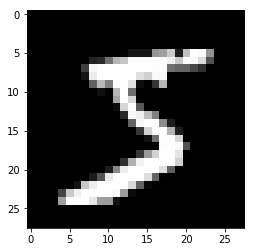

In [0]:
plot_mnist_image(x_train[0])

In [0]:
print("Unsoftened probabilities: ", unsoftened_train_prob[0])
print()
print("Prediction based on unsoftened probability: ", np.argmax(unsoftened_train_prob[0]))

Unsoftened probabilities:  [2.9399757e-23 7.7865502e-24 3.3027068e-24 6.2618165e-16 1.4026793e-27
 7.1093457e-12 2.4744464e-21 3.6832551e-24 9.0432768e-20 5.3667499e-19]

Prediction based on unsoftened probability:  5


In [0]:
temperature = 4
softened_train_prob = softmax_with_temperature(model_logits, temperature)

In [0]:
print("Softened probabilities: ", softened_train_prob[0])
print()
print("Prediction based on Softened probability: ", np.argmax(softened_train_prob[0]))

Softened probabilities:  [5.1947024e-09 3.7265848e-09 3.0074072e-09 3.5289850e-07 4.3173209e-10
 3.6427730e-06 1.5734186e-08 3.0905281e-09 3.8686210e-08 6.0381318e-08]

Prediction based on Softened probability:  5


In [0]:
def build_small_model():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Flatten()(inputs)
    x = layers.Dense(128, activation='relu', name='FC1')(x)
    x = layers.Dense(128, activation='relu', name='FC2')(x)
    x = layers.Dense(10, name='logits')(x)
    preds = layers.Activation('softmax', name='Softmax')(x)

    model = Model(inputs=inputs, outputs=preds)
    model.summary()
    return model

In [0]:
small_model = build_small_model()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               100480    
_________________________________________________________________
FC2 (Dense)                  (None, 128)               16512     
_________________________________________________________________
logits (Dense)               (None, 10)                1290      
_________________________________________________________________
Softmax (Activation)         (None, 10)                0         
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_____________________________________________________

In [0]:
small_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
small_model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.2584 - acc: 0.9252
Epoch 2/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.1079 - acc: 0.9681
Epoch 3/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0749 - acc: 0.9772
Epoch 4/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0571 - acc: 0.9818
Epoch 5/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0432 - acc: 0.9858
Epoch 6/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0378 - acc: 0.9876
Epoch 7/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0276 - acc: 0.9910
Epoch 8/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0246 - acc: 0.9917
Epoch 9/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0211 - acc: 0.9929
Epoch 10/10
60000/60000 [==============================] - 2s 40us/sample - loss: 

In [0]:
test_loss, test_acc = small_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

10000/10000 [==============================] - 1s 54us/sample - loss: 0.0842 - acc: 0.9790
Test Loss: 0.08423439382088946
Test Accuracy: 0.979


In [0]:
"""
Knowledge Transfering
"""

new_small_model = build_small_model()
logits = new_small_model.get_layer('logits').output
logits = layers.Lambda(lambda x: x / temperature, name='Temperature')(logits)
preds = layers.Activation('softmax', name='Softmax')(logits)
  
new_small_model = Model(inputs=new_small_model.input, outputs=preds)
print("New Model Summary")
new_small_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 128)               100480    
_________________________________________________________________
FC2 (Dense)                  (None, 128)               16512     
_________________________________________________________________
logits (Dense)               (None, 10)                1290      
_________________________________________________________________
Softmax (Activation)         (None, 10)                0         
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_____________________________________________________

In [0]:
new_small_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
new_small_model.fit(x_train, softened_train_prob, epochs=10, batch_size=64)

Epoch 1/10
60000/60000 [==============================] - 3s 43us/sample - loss: 221.2708 - acc: 0.1010
Epoch 2/10
60000/60000 [==============================] - 2s 41us/sample - loss: 239.9347 - acc: 0.1012
Epoch 3/10
60000/60000 [==============================] - 2s 41us/sample - loss: 242.7868 - acc: 0.0992
Epoch 4/10
60000/60000 [==============================] - 2s 41us/sample - loss: 228.1774 - acc: 0.1003
Epoch 5/10
60000/60000 [==============================] - 2s 41us/sample - loss: 237.0359 - acc: 0.1010
Epoch 6/10
60000/60000 [==============================] - 2s 41us/sample - loss: 231.9363 - acc: 0.1014
Epoch 7/10
60000/60000 [==============================] - 2s 41us/sample - loss: 220.2623 - acc: 0.1022
Epoch 8/10
60000/60000 [==============================] - 2s 41us/sample - loss: 243.5526 - acc: 0.1031
Epoch 9/10
60000/60000 [==============================] - 2s 41us/sample - loss: 235.3285 - acc: 0.1000
Epoch 10/10
60000/60000 [==============================] - 2s 41

In [0]:
test_loss, test_acc = new_small_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

10000/10000 [==============================] - 1s 55us/sample - loss: 11595710.4640 - acc: 0.0958
Test Loss: 11595710.464
Test Accuracy: 0.0958
